# Detailed ILF3 plots for Simon

First, let's get to know transcription cluster ID of ILF3

In [41]:
import redis
import numpy
import transvis.io as t
import matplotlib.pyplot as plt
%matplotlib inline


In [42]:
t.initDB()

In [43]:
trans_ILF3 = list(t.geneToTrans("ILF3"))
assert(len(trans_ILF3) == 1)
trans_id = trans_ILF3[0]
trans_id

'3820663'

In [44]:
def avg(data):
    return sum(data)/len(data)

We can now pull out the "good", GENECODE pre-filtered probes, print their count and the IDs of the first 10 probesets

In [45]:
probeset_ids = list(t.transToProbeset(trans_id))
print("number of probeset probeset_ids:", len(probeset_ids))
print("first ten probeset IDs: ", probeset_ids[:10])

number of probeset probeset_ids: 58
first ten probeset IDs:  ['3820680', '3820674', '3820683', '3820702', '3820708', '3820719', '3820679', '3820692', '3820675', '3820698']


# All probesets (with probe averages)

As per Simon's request, but the plot is a bit too messy to see anything

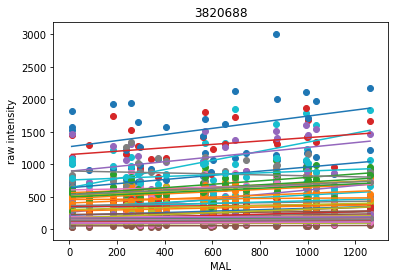

In [46]:
for probeset in probeset_ids:
    plt.title(probeset)
    plt.xlabel("MAL")
    plt.ylabel("raw intensity")
    data_for_probeset = [avg(probeset) for probeset in t.probesetPatientData(probeset)]
    MAL = [i[0] for i in t.alleleData()]
    plt.scatter(MAL, data_for_probeset)
    plt.plot(numpy.unique(MAL), numpy.poly1d(numpy.polyfit(MAL, data_for_probeset, 1))(numpy.unique(MAL)))

# Probes within a probeset

The major learning from this plot is that there's big disagreement across probes within a probeset, but a good agreement across patients within the cohort.

`3820696` is an interesting "unsure" probeset.
`3820698` is an interesting, highly expressed strongly going up probeset
`3820699` is another interesting probeset, which both highly expressed, very small and going up

/apps/transvis/venv3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


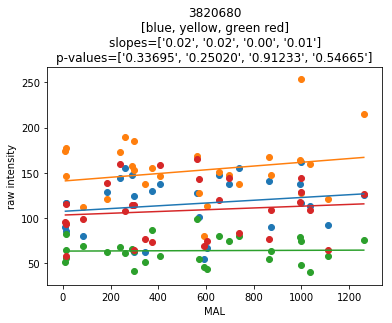

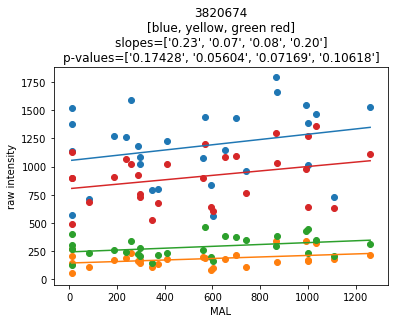

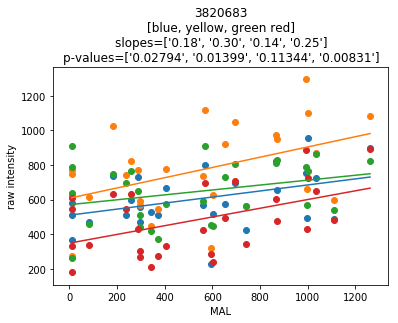

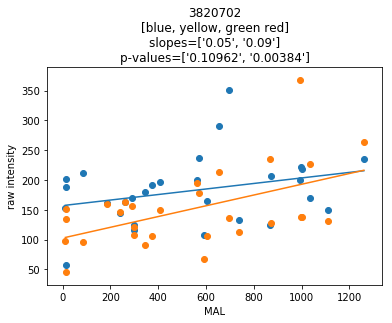

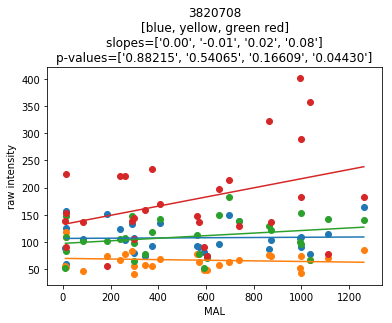

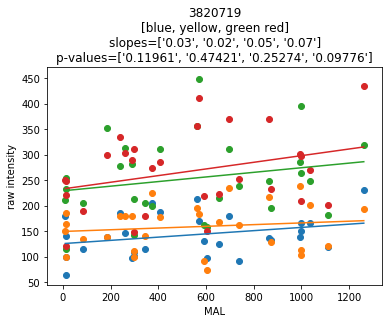

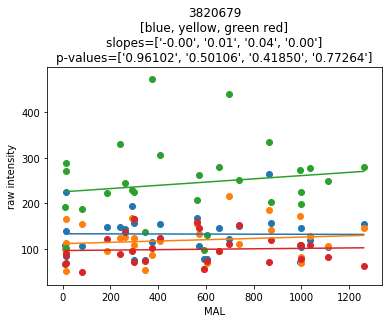

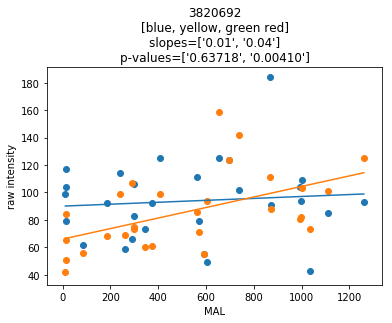

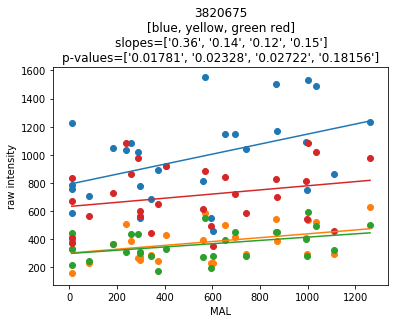

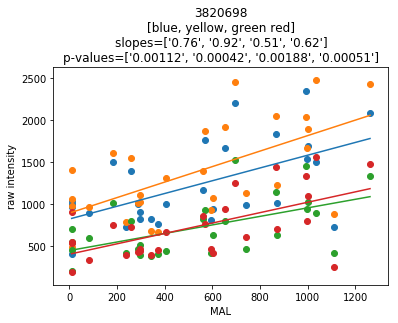

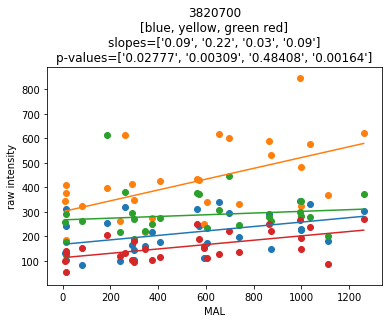

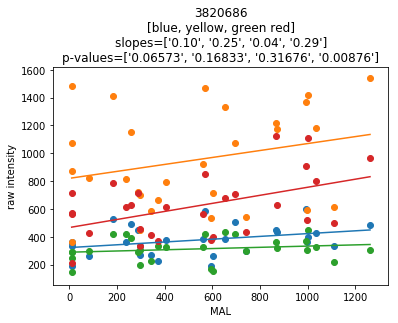

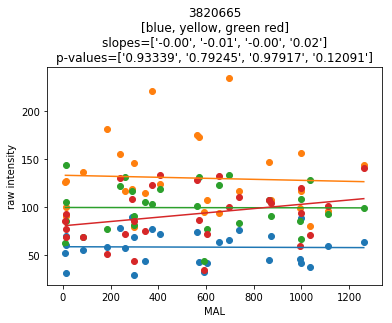

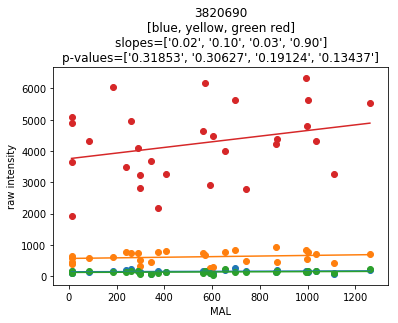

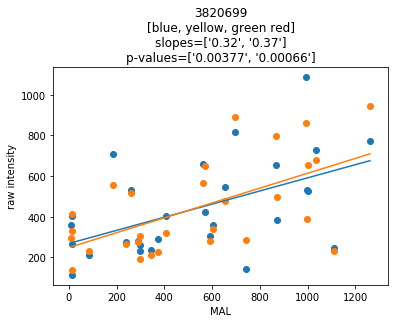

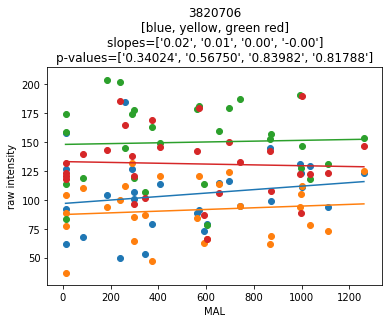

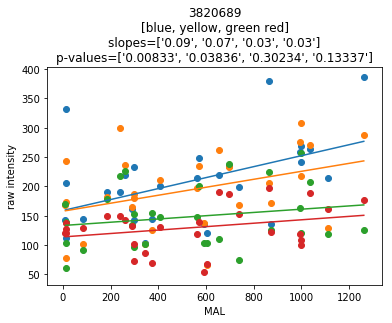

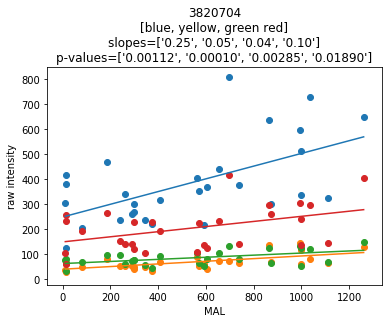

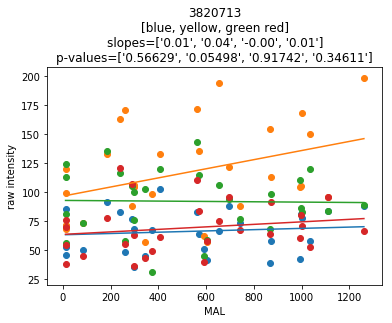

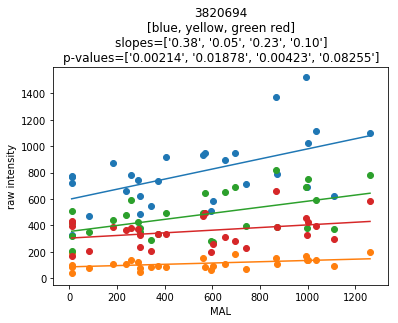

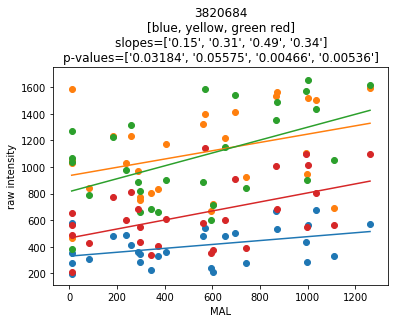

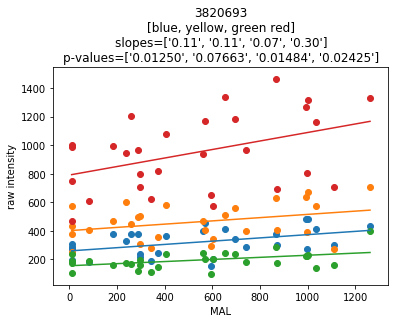

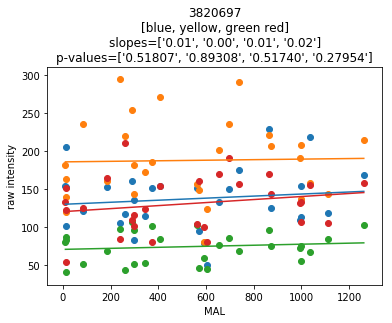

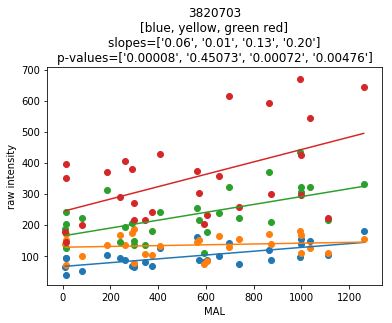

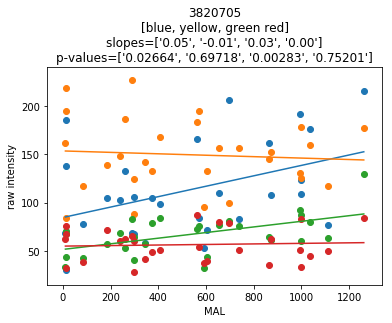

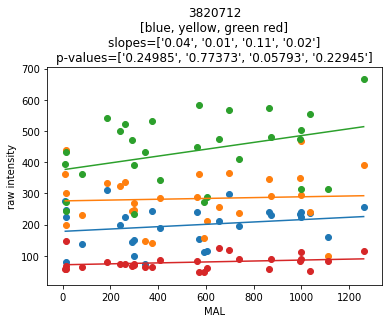

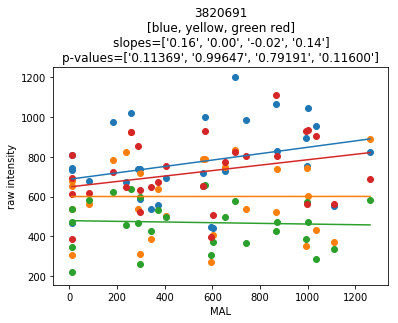

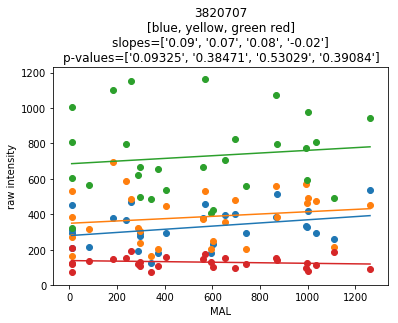

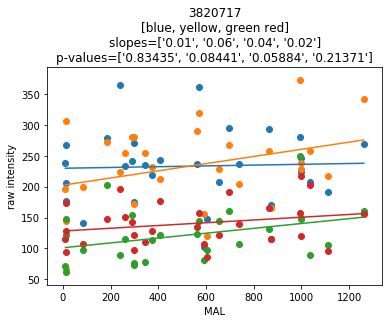

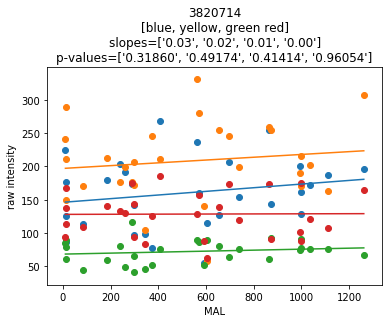

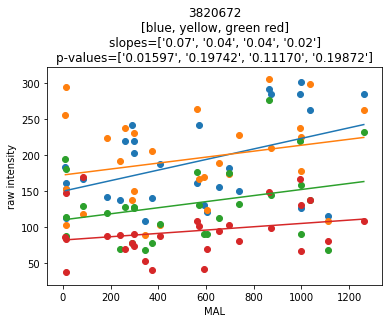

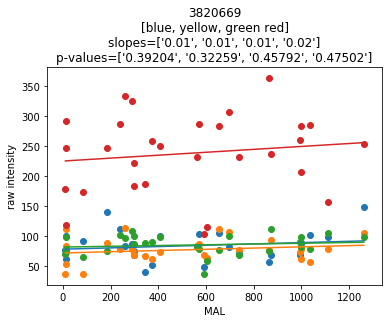

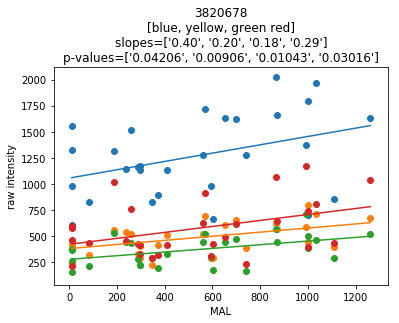

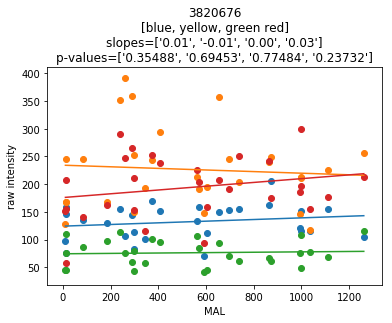

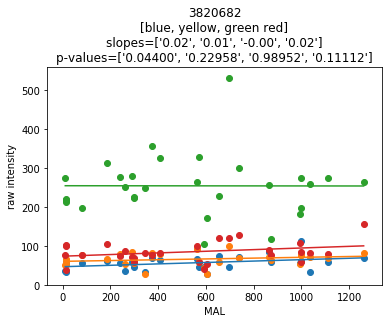

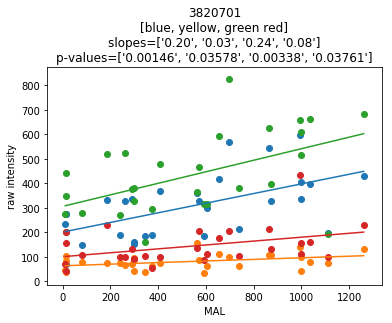

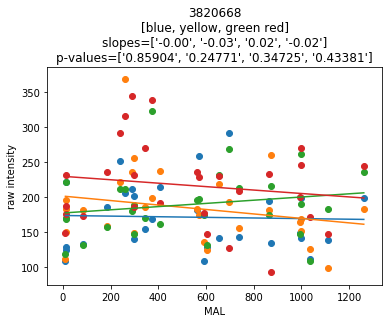

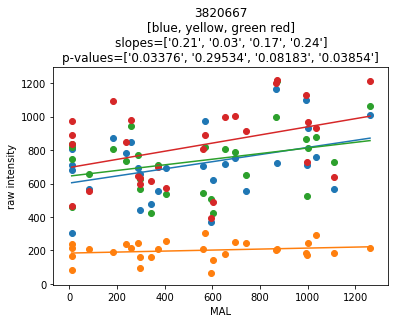

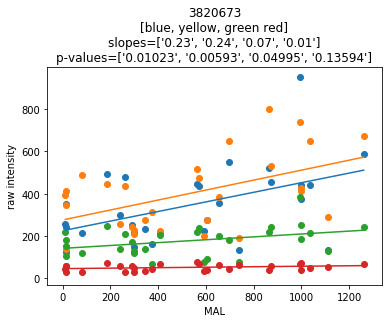

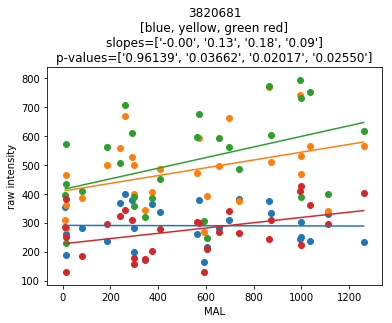

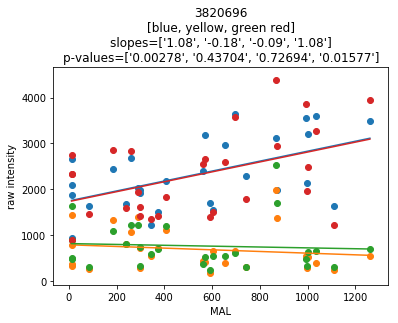

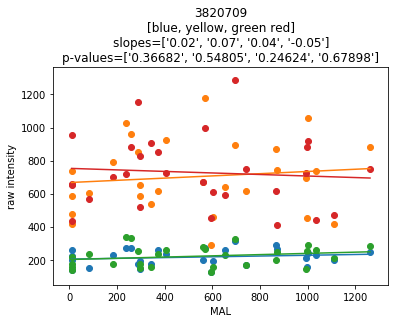

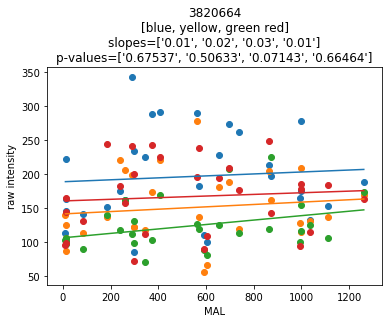

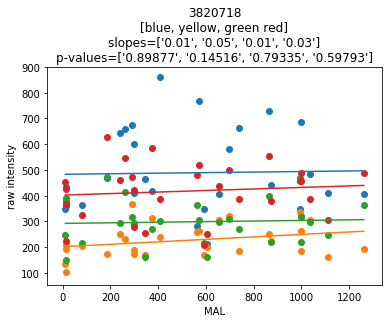

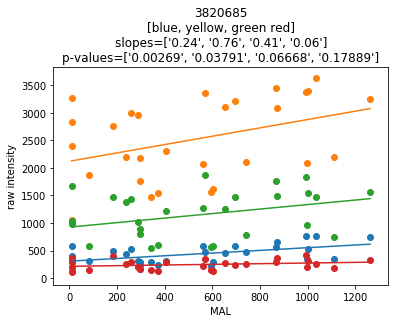

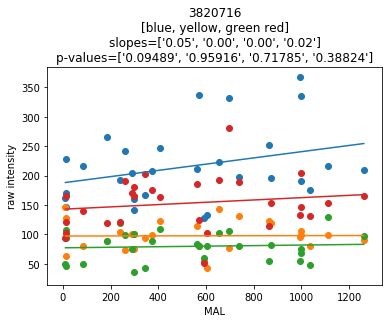

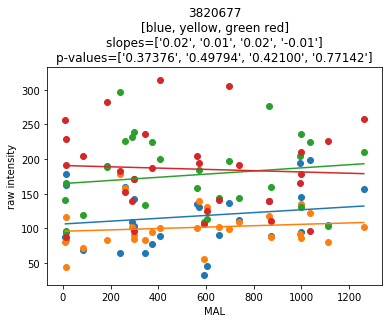

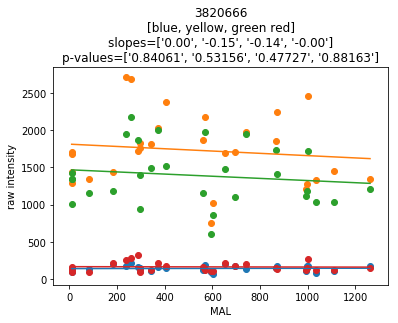

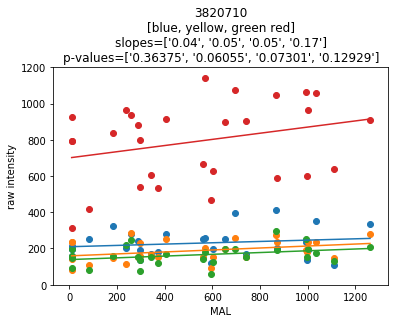

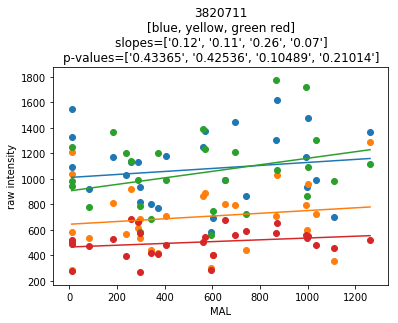

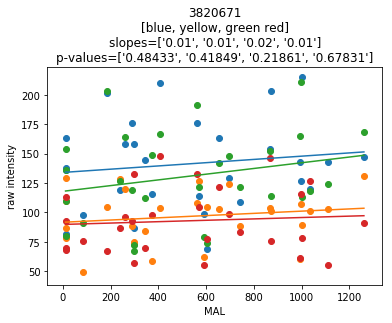

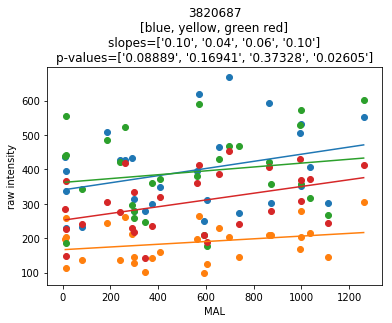

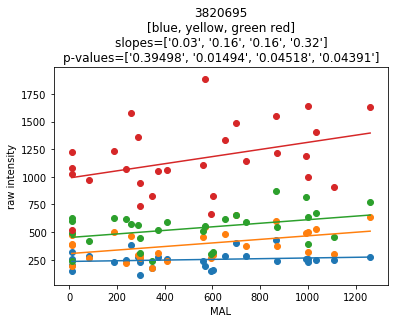

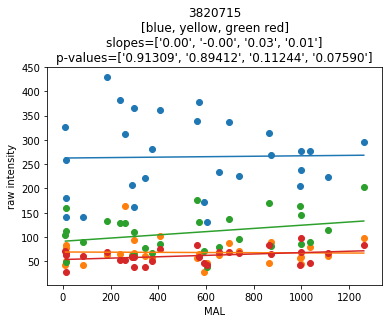

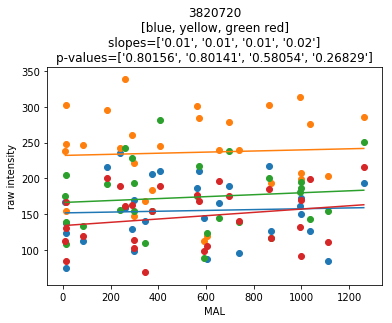

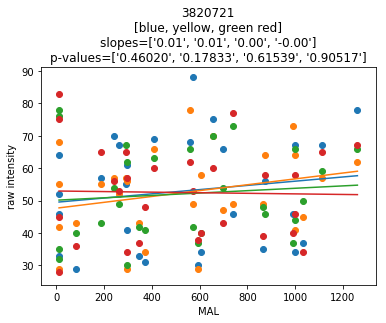

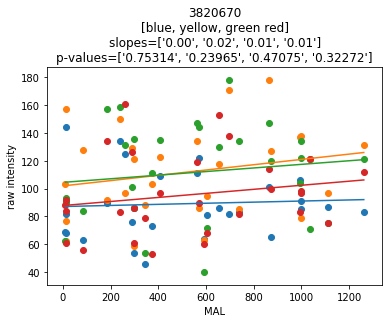

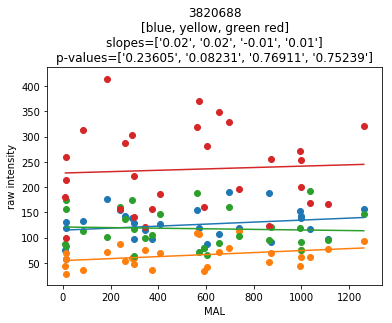

In [47]:
import scipy.stats
plt.figure()
slope_pvalue_intensity_position = []
for probeset_key in probeset_ids:
    #
    #
    probesets = t.probesetData(probeset_key)
    #probesets = t.probesetPatientData(probeset)
    plt.figure()
    slopes = []
    pvalues = []
    for probeset in probesets:
        plt.xlabel("MAL")
        plt.ylabel("raw intensity")
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MAL, probeset)
        left = t.probesetAnnotationMetadata(probeset_key)[3]
        slope_pvalue_intensity_position.append([slope, p_value, avg(probeset), left])
        slopes.append("{:.2f}".format(slope))
        pvalues.append("{:.5f}".format(p_value))
        plt.title(probeset_key + str("\n[blue, yellow, green red]\nslopes=") + str(slopes) + str("\np-values=") + str(pvalues))
        plt.scatter(MAL, probeset)
        plt.plot(numpy.unique(MAL), numpy.poly1d(numpy.polyfit(MAL, probeset, 1))(numpy.unique(MAL)))

In [48]:
zipped_properties = list(zip(*slope_pvalue_intensity_position))
slope, intensity, pvalues, position = zipped_properties[0], zipped_properties[2], zipped_properties[1], zipped_properties[3]

# slope vs intensity

As per John's request. Indeed, the more expressed probesets have higher slopes

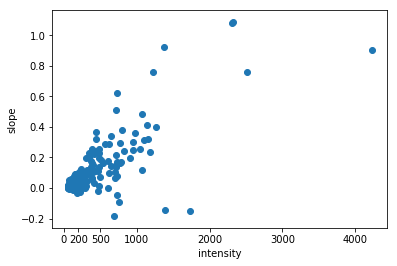

In [49]:
plt.xlabel("intensity")
plt.ylabel("slope")
plt.scatter(intensity, slope)
plt.xticks([0, 200, 500, 1000, 2000, 3000, 4000])
pass

# Slopes, p-values and intensities well-ordered as they would occur in the sense strand.

## slope

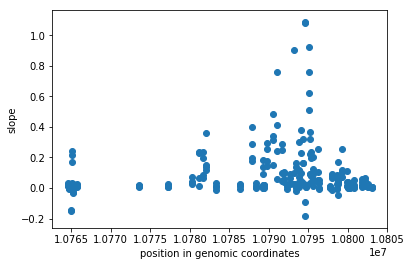

In [50]:
plt.xlabel("position in genomic coordinates")
plt.ylabel("slope")
plt.scatter(position, slope)
pass

## p-values

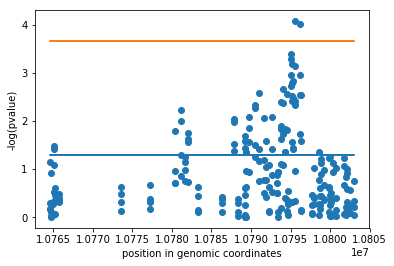

In [69]:
import math
plt.xlabel("position in genomic coordinates")
plt.ylabel("-log(pvalue)")
plt.scatter(position, [-math.log(pvalue, 10) for pvalue in pvalues])
plt.plot(position, [-math.log(0.05, 10)] * len(position))
plt.plot(position, [-math.log(0.05/len(position), 10)] * len(position))
pass

## non-logged p-values

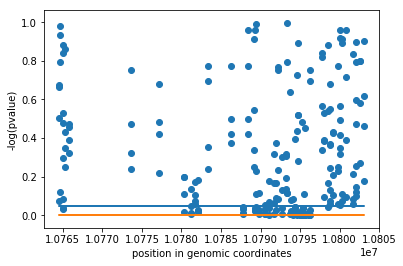

In [74]:
import math
plt.xlabel("position in genomic coordinates")
plt.ylabel("-log(pvalue)")
plt.scatter(position, pvalues)
plt.plot(position, [0.05] * len(position))
plt.plot(position, [0.05/len(position)] * len(position))
pass

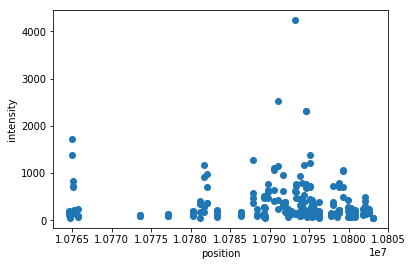

In [51]:
plt.xlabel("position")
plt.ylabel("intensity")
plt.scatter(position, intensity)
pass

# Interactive plot picker (position gets multiplied by 10**7)

In [52]:
def cherry_pick(left_position, right_position, min_intensity):
    import scipy.stats
    plt.figure()
    slope_pvalue_intensity_position = []
    count = 0
    for probeset_key in probeset_ids:
        probesets = list(t.probesetData(probeset_key))
        #probesets = t.probesetPatientData(probeset)
        left = t.probesetAnnotationMetadata(probeset_key)[3]
        intensities = []
        for probeset in probesets:
            for intensity in probeset:
                intensities.append(intensity)
        if left < right_position * 10**7 and left_position * 10**7 < left and avg(intensities) > min_intensity:
            plt.figure()
            plt.xlabel("MAL")
            plt.ylabel("raw intensity")
            count += 1
            slopes = []
            pvalues = []
            for probeset in probesets:
                avg_intensity = avg(probeset)
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MAL, probeset)
                slope_pvalue_intensity_position.append([slope, p_value, avg(probeset), left])
                slopes.append("{:.2f}".format(slope))
                pvalues.append("{:.5f}".format(p_value))
                plt.title(probeset_key + str("\n[blue, yellow, green red]\nslopes=") + str(slopes) + str("\np-values=") + str(pvalues))
                plt.scatter(MAL, probeset)
                plt.plot(numpy.unique(MAL), numpy.poly1d(numpy.polyfit(MAL, probeset, 1))(numpy.unique(MAL)))

# Interesting region

pay attention to probeset `382073`, Interesting probeset is actually the least expressed, with average expression less than about 100.

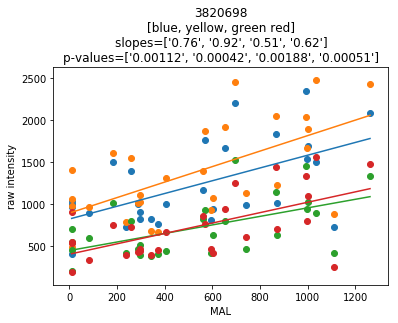

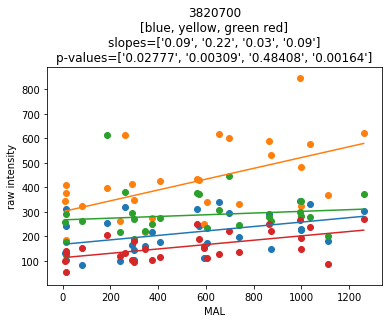

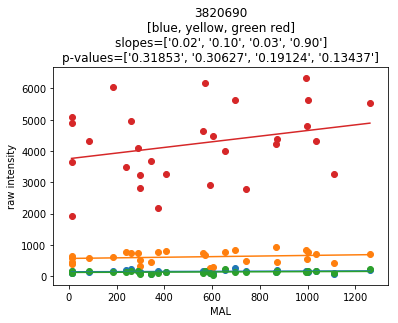

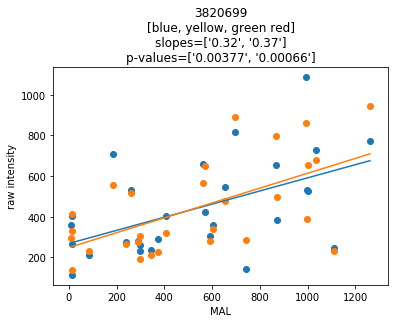

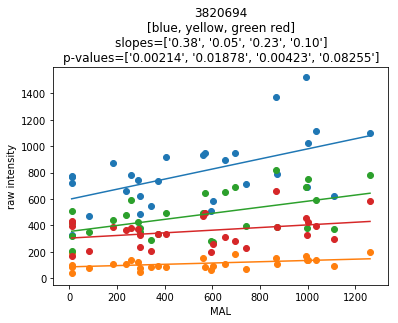

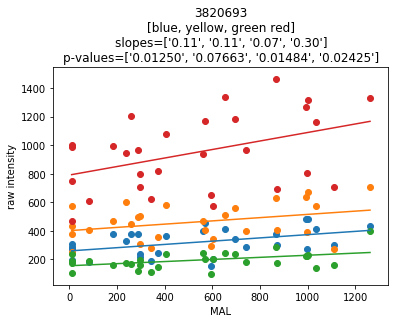

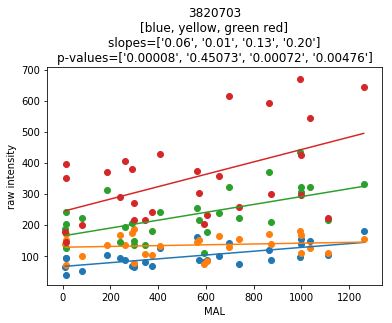

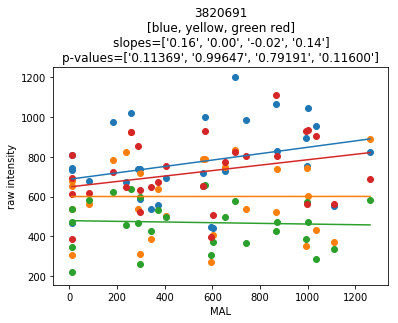

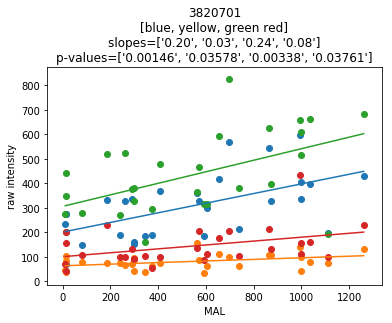

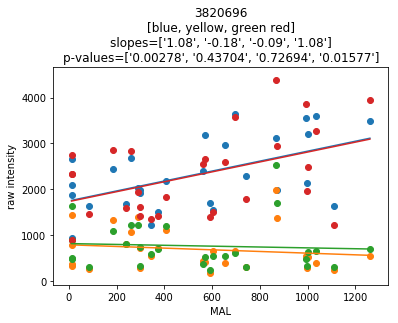

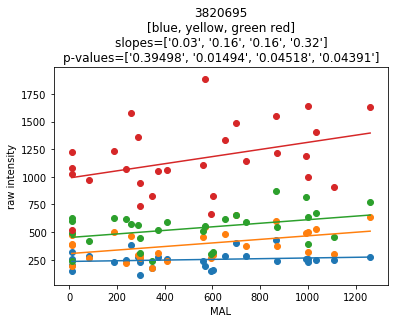

In [53]:
left_position = 1.0793
right_position = 1.0797
min_intensity = 200
cherry_pick(left_position, right_position, min_intensity)

# Boring region

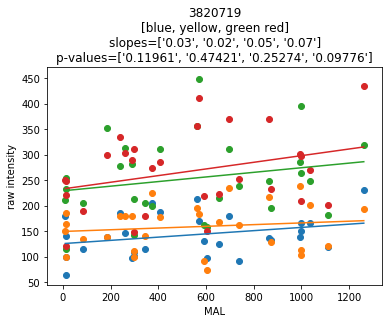

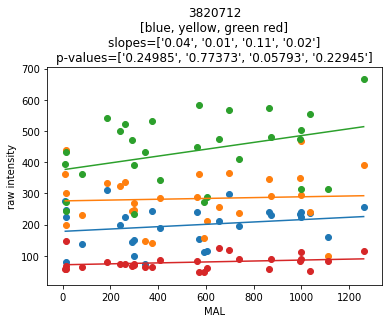

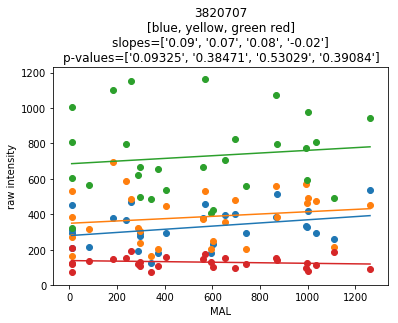

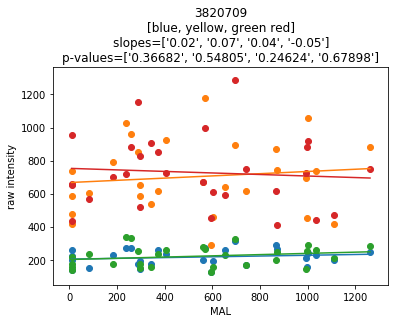

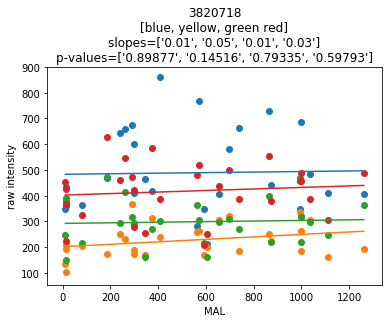

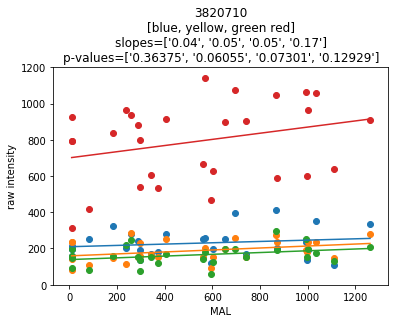

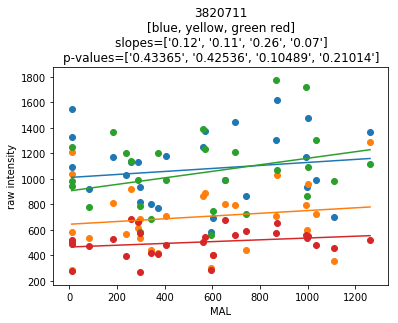

In [67]:
left_position = 1.0797
right_position = 1.0803
min_intensity = 200
cherry_pick(left_position, right_position, min_intensity)